# Prediction of the number of migrations between two districts per year Ridge (L2)

In [1]:
import math
import cmath
import lxml
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/pop_dyn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def normalize_features(feature_vector, columns_to_scale):
    for feature in columns_to_scale:
        scaler = StandardScaler(with_mean=0, with_std=1)
        feature_vector[feature] = scaler.fit_transform(feature_vector[feature])
    return feature_vector

def split_train_test_by_quartiles(feature_vector, feature_columns, target_column, n_splits_dist, labels, train_size):
    X = feature_vector.loc[:, (feature_columns)]
    y = feature_vector.loc[:, target_column]
    
    # extract quartiles from continuous target to equally split between train/test
    label_list = pd.qcut(feature_vector[target_column], n_splits_dist, labels=labels).tolist()
    
    # Split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=32, 
                                                                  stratify=label_list)
    return X_train, X_test, y_train, y_test

def split_x_y(data, x_columns, y_column):
    X = data.loc[:,(x_columns)]
    Y = data.loc[:,(y_column)]
    return X, Y

In [3]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

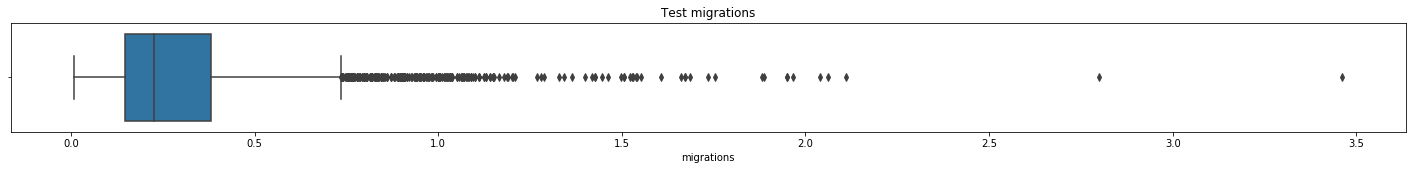

In [4]:
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(f_vector['migrations'])

In [5]:
f_vector[f_vector['migrations'] > 2.5]

,migrations,destination,origin,year,n_inhabitants_or,net_income_or,euribor,density_or,rev_1000_inh_or,var_review_or,...,rev_1000_inh_diff,var_review_diff,unemployed_diff,eldery_perc_diff,d_inner_n_diff,d_outer_n_diff,var_sale_m2_diff,var_rent_m2_diff,n_tran_rs_diff,n_tran_new_rs_diff
316,3.461478,Villa de Vallecas,Puente de Vallecas,2007,461817.0,23405.03,4.064,152.05,0.0,0.0,...,0.0,0.0,-0.076640,-5.222267,3.178951,-0.369562,0.113030,1.609018,16.677943,16.677943
1076,2.799199,Villa de Vallecas,Puente de Vallecas,2009,469133.0,23405.03,2.622,152.05,0.0,0.0,...,0.0,0.0,-0.111384,-5.991983,3.770764,-0.435502,5.080003,2.850579,18.237017,18.237017


In [6]:
# Remove the two outliers with values higher than 50
f_vector = f_vector[f_vector['migrations'] < 2.5] 

In [7]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'year', 'n_inhabitants_or',
       'net_income_or', 'euribor', 'density_or', 'rev_1000_inh_or',
       'var_review_or', 'unemployed_or', 'eldery_perc_or', 'd_inner_n_or',
       'd_outer_n_or', 'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or',
       'n_tran_rs_or', 'n_tran_new_rs_or', 'mortage_executions',
       'n_inhabitants_de', 'net_income_de', 'density_de', 'rev_1000_inh_de',
       'var_review_de', 'unemployed_de', 'eldery_perc_de', 'd_inner_n_de',
       'd_outer_n_de', 'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de',
       'n_tran_new_rs_de', 'net_income_diff', 'density_diff',
       'rev_1000_inh_diff', 'var_review_diff', 'unemployed_diff',
       'eldery_perc_diff', 'd_inner_n_diff', 'd_outer_n_diff',
       'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_rs_diff',
       'n_tran_new_rs_diff'],
      dtype='object')

In [8]:
f_vector.loc[f_vector[f_vector['year'] <= 2008].index, 'period'] = 0
f_vector.loc[f_vector[(f_vector['year'] > 2008) & (f_vector['year'] <= 2011)].index, 'period'] = 2
f_vector.loc[f_vector[f_vector['year'] > 2011].index, 'period'] = 1

In [9]:
feature_columns = ['net_income_or', 'density_or', 'rev_1000_inh_or', 'unemployed_or', 'eldery_perc_or', 
                   'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_new_rs_or', 'var_review_or',
                   'n_tran_new_rs_de', "mortage_executions", 'var_n_biz' ,
                   'net_income_de', 'rev_1000_inh_de', 'var_review_de', 'unemployed_de','eldery_perc_de', 
                   "var_sale_m2_de", "var_rent_m2_de", "density_de", 'n_tran_rs_or',
                   'n_tran_rs_de']
target_column = "migrations"
n_splits_dist = 5
labels = ["q1","q2","q3","q4","q5"]
train_size = 0.9
alpha = 0.25
alpha_reg = 0.05

### Build train/test data sets

In [10]:
# Scale features
feature_vector = normalize_features(f_vector, feature_columns)
#feature_vector = f_vector.copy()
feature_vector['period'] = feature_vector['period'].astype(int)

# Calculate variance for each feature
f_variance = [np.var(feature_vector[col].tolist()) for col in feature_vector.columns if col in feature_columns]

# Split by features and target
X, Y = split_x_y(feature_vector, feature_columns + ['period'], target_column)

In [11]:
X.shape

(3798, 23)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [12]:
# Train linear regression and predict migrations
X_total = X.drop(['period'], axis=1)

reg = linear_model.Ridge(alpha=alpha_reg, fit_intercept=True)
reg = reg.fit(X_total, Y)
params = np.append(reg.intercept_, reg.coef_)
y_pred = reg.predict(X_total)
summary = pd.DataFrame({'factors': feature_columns, 'coefficients': reg.coef_})
print(f"r2 score: {reg.score(X_total.as_matrix(), Y)}")

# Calculate the mean square error between true and predicted values MSE = 1*df^(-1) * SUM(ytrue - ypred)^2
# Degrees of freedom = n_samples - n_features - 1
df = len(X_total) - len(X_total.columns) -1 
MSE = (sum((Y-y_pred)**2))/df

# Calculate the covariance between Y and each X
var_b = MSE * np.array(f_variance)
sd_b = np.sqrt(var_b) # standard deviation for each feature
ts_b = reg.coef_/ sd_b # t-student values for each feature

scaler = StandardScaler(with_mean=0, with_std=1)
ts_b_scale = scaler.fit_transform(ts_b)

# Calculate the two-sided p-value form t-student value:
# p-value = 2 * stats.t.sf(np.abs(t-student-value), degree_of_freedom) = 
# p-value = 2 * (1 - stats.t.cdf(np.abs(t-student-value), degree_of_freedom))
p_values = [2 * (1 - stats.t.cdf(np.abs(i), df)) for i in ts_b_scale]

sd_b = np.round(sd_b,3)
ts_b_scale = np.round(ts_b_scale,3)
p_values = np.round(p_values,3)

summary["standard errors"],summary["t values"],summary["p-values"] = [sd_b,ts_b_scale,p_values]

r2 score: 0.12687728478202442


In [13]:
summary

,factors,coefficients,standard errors,t values,p-values
0,net_income_or,0.005288,0.235,0.256,0.798
1,density_or,0.070261,0.235,3.402,0.001
2,rev_1000_inh_or,0.012686,0.235,0.614,0.539
3,unemployed_or,-0.004772,0.235,-0.231,0.817
4,eldery_perc_or,-0.021826,0.235,-1.057,0.291
5,var_sale_m2_or,-0.003320,0.235,-0.161,0.872
6,var_rent_m2_or,-0.003951,0.235,-0.191,0.848
7,n_tran_new_rs_or,-0.001036,0.235,-0.050,0.960
8,var_review_or,0.001723,0.235,0.083,0.934
9,n_tran_new_rs_de,0.021823,0.235,1.057,0.291


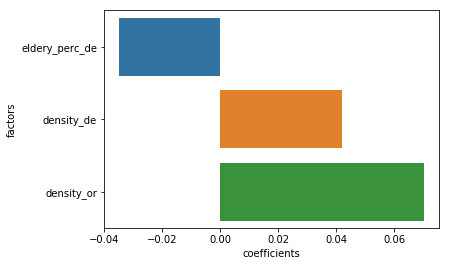

In [14]:
summary = summary.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary[summary['p-values'] < alpha])
significant_factors = summary[summary['p-values'] < alpha]

### Evaluate performance of the model

In [15]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y, y_pred)))

The RMSE in the test data set is: 0.23
 The r2 score in the test data set is: 0.13


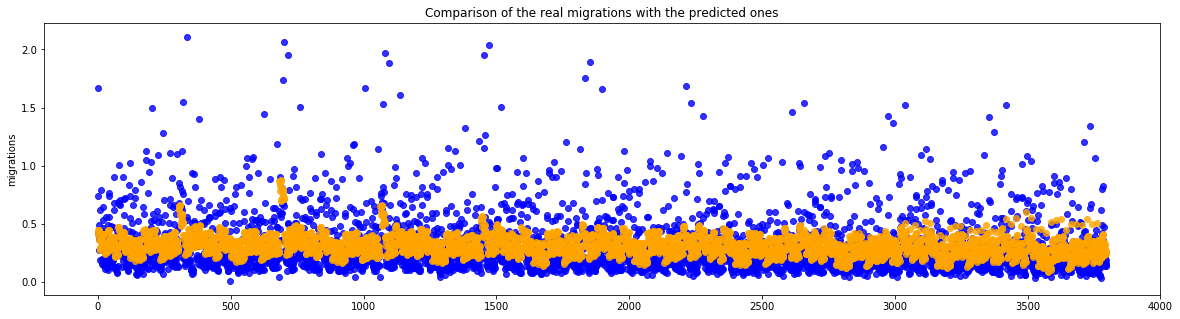

In [16]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y)), y=Y, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

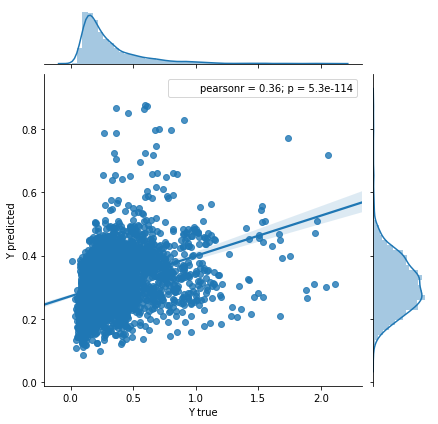

In [17]:
_=sns.jointplot(x=Y, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Compare factors correlation with the internal migrations per period (pre, during, after crisis)

### Linear model until the economical crisis 2008

In [18]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_b = f_vector[f_vector['period']==0]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'year', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]
feature_vector_b = normalize_features(feature_vector_b, feature_columns_)

# Calculate variance for each feature
f_var_b = [np.var(feature_vector_b[col].tolist()) for col in feature_vector_b.columns if col in feature_columns_]

# Split by features and target
X_b, Y_b = split_x_y(feature_vector_b, feature_columns_, target_column)

# Train linear regression and predict migrations
reg_b = linear_model.Ridge(alpha=alpha_reg, fit_intercept=True)
reg_b = reg_b.fit(X_b,Y_b)
y_pred_b = reg_b.predict(X_b)
summary_b = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_b.coef_})
print(f"r2 score: {reg.score(X_total.as_matrix(), Y)}")

# Calculate the mean square error between true and predicted values MSE = 1*df^(-1) * SUM(ytrue - ypred)^2
# Degrees of freedom = n_samples - n_features - 1
df = len(X_b) - len(X_b.columns) -1 
MSE = (sum((Y_b-y_pred_b)**2))/df

# Calculate the covariance between Y and each X
var = MSE * np.array(f_var_b)
sd = np.sqrt(var) # standard deviation for each feature
ts = reg_b.coef_/ sd # t-student values for each feature

scaler = StandardScaler(with_mean=0, with_std=1)
ts_scale = scaler.fit_transform(ts)

# Calculate the two-sided p-value form t-student value:
# p-value = 2 * stats.t.sf(np.abs(t-student-value), degree_of_freedom) = 
# p-value = 2 * (1 - stats.t.cdf(np.abs(t-student-value), degree_of_freedom))
p_values = [2 * stats.t.sf(np.abs(i), df) for i in ts_scale]

sd = np.round(sd,3)
ts_scale = np.round(ts_scale,3)
p_values = np.round(p_values,3)

summary_b["standard errors"], summary_b["t values"], summary_b["p-values"] = [sd,ts_scale,p_values]

r2 score: 0.12687728478202442


In [19]:
summary_b

,factors,coefficients,standard errors,t values,p-values
0,net_income_or,0.026138,0.252,0.894,0.372
1,density_or,0.071755,0.252,2.454,0.014
2,unemployed_or,0.031870,0.252,1.090,0.276
3,eldery_perc_or,-0.016987,0.252,-0.581,0.562
4,var_sale_m2_or,-0.006884,0.252,-0.235,0.814
5,var_rent_m2_or,-0.009876,0.252,-0.338,0.736
6,n_tran_new_rs_or,-0.006226,0.252,-0.213,0.831
7,n_tran_new_rs_de,0.025998,0.252,0.889,0.374
8,mortage_executions,-0.018186,0.252,-0.622,0.534
9,var_n_biz,0.018186,0.252,0.622,0.534


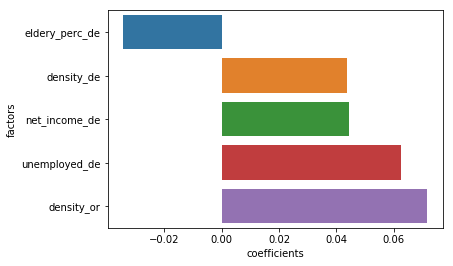

In [20]:
summary_b = summary_b.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_b[summary_b['p-values'] < alpha])
significant_factors_b = summary_b[summary_b['p-values'] < alpha]

In [21]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_b, y_pred_b))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_b, y_pred_b)))

The RMSE in the test data set is: 0.25
 The r2 score in the test data set is: 0.15


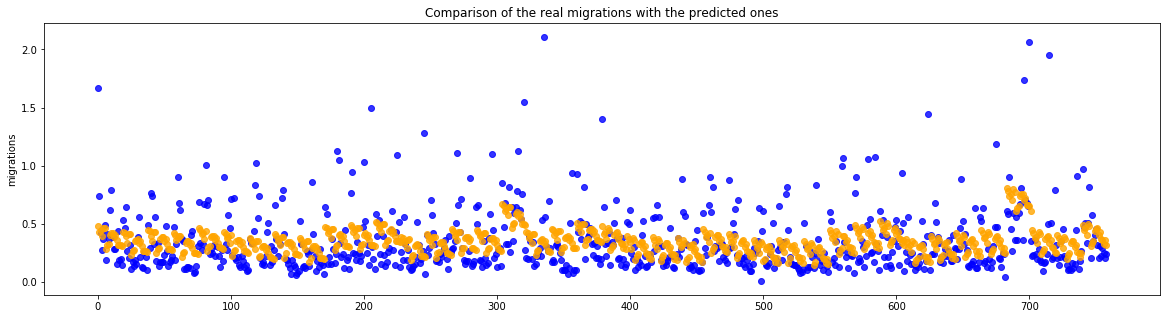

In [22]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_b)), y=Y_b, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_b)), y=y_pred_b, fit_reg=False, color="orange")

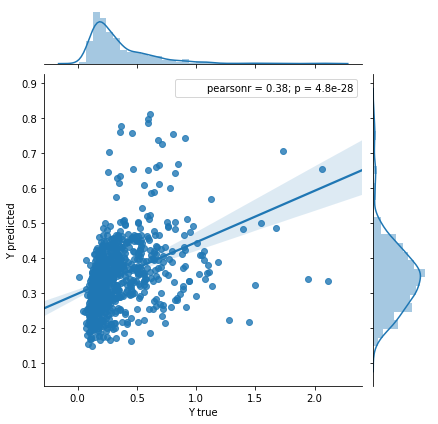

In [23]:
_=sns.jointplot(x=Y_b, y=y_pred_b, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

### Linear model during the crisis 2009-2011

In [24]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_d = f_vector[f_vector['period']==2]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'year', 'rev_1000_inh_or','var_review_or',
                                                            'rev_1000_inh_de','var_review_de']]
feature_vector_d = normalize_features(feature_vector_d, feature_columns_)

# Calculate variance for each feature
f_var_d = [np.var(feature_vector_d[col].tolist()) for col in feature_vector_d.columns if col in feature_columns_]

# Split by features and target
X_d, Y_d = split_x_y(feature_vector_d, feature_columns_, target_column)

# Train linear regression and predict migrations
reg_d = linear_model.Ridge(alpha=alpha_reg, fit_intercept=True)
reg_d = reg_d.fit(X_d,Y_d)
y_pred_d = reg_d.predict(X_d)
summary_d = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_d.coef_})

# Calculate the mean square error between true and predicted values MSE = 1*df^(-1) * SUM(ytrue - ypred)^2
# Degrees of freedom = n_samples - n_features - 1
df = len(X_d) - len(X_d.columns) -1 
MSE = (sum((Y_d-y_pred_d)**2))/df

# Calculate the covariance between Y and each X
var = MSE * np.array(f_var_d)
sd = np.sqrt(var) # standard deviation for each feature
ts = reg_d.coef_/ sd # t-student values for each feature

scaler = StandardScaler(with_mean=0, with_std=1)
ts_scale = scaler.fit_transform(ts)

# Calculate the two-sided p-value form t-student value:
# p-value = 2 * stats.t.sf(np.abs(t-student-value), degree_of_freedom) = 
# p-value = 2 * (1 - stats.t.cdf(np.abs(t-student-value), degree_of_freedom))
p_values = [2 * stats.t.sf(np.abs(i), df) for i in ts_scale]

sd = np.round(sd,3)
ts_scale = np.round(ts_scale,3)
p_values = np.round(p_values,3)

summary_d["standard errors"], summary_d["t values"], summary_d["p-values"] = [sd,ts_scale,p_values]

In [25]:
summary_d

,factors,coefficients,standard errors,t values,p-values
0,net_income_or,0.041692,0.246,1.056,0.291
1,density_or,0.080511,0.246,2.040,0.042
2,unemployed_or,0.046100,0.246,1.168,0.243
3,eldery_perc_or,-0.018811,0.246,-0.477,0.634
4,var_sale_m2_or,-0.001967,0.246,-0.050,0.960
5,var_rent_m2_or,-0.003074,0.246,-0.078,0.938
6,n_tran_new_rs_or,-0.005701,0.246,-0.144,0.885
7,n_tran_new_rs_de,0.023809,0.246,0.603,0.547
8,mortage_executions,0.117171,0.246,2.968,0.003
9,var_n_biz,0.099197,0.246,2.513,0.012


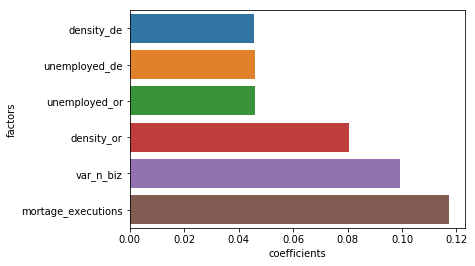

In [26]:
summary_d = summary_d.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_d[summary_d['p-values'] < alpha])
significant_factors_d = summary_d[summary_d['p-values'] < alpha]

In [27]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_d, y_pred_d))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_d, y_pred_d)))

The RMSE in the test data set is: 0.24
 The r2 score in the test data set is: 0.14


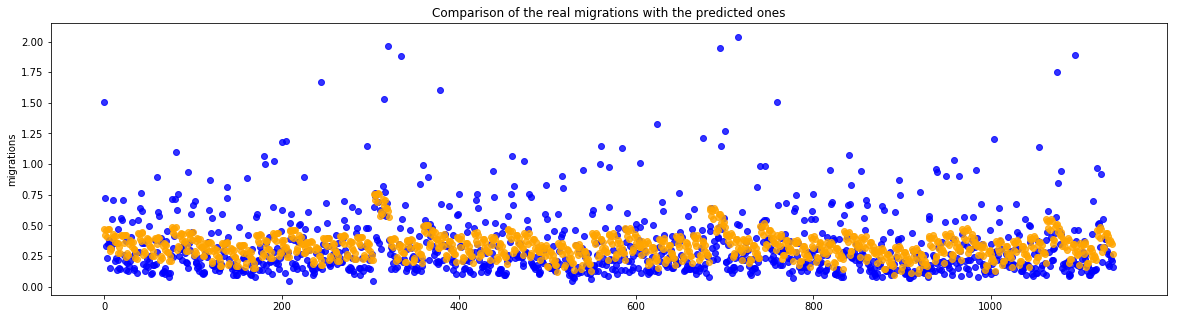

In [28]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_d)), y=Y_d, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_d)), y=y_pred_d, fit_reg=False, color="orange")

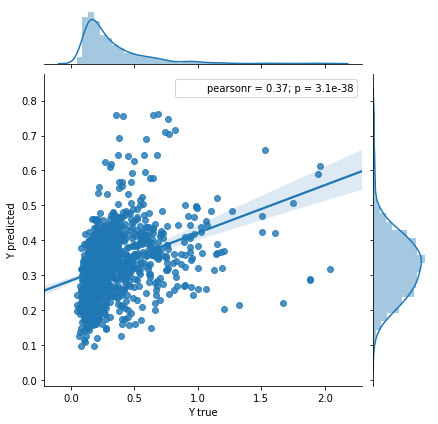

In [29]:
_=sns.jointplot(x=Y_d, y=y_pred_d, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

### Linear model after the european crisis of 2011

In [30]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_a = f_vector[f_vector['period']==1]
feature_columns_ = [x for x in feature_columns if x not in ['period', 'year']]
feature_vector_a = normalize_features(feature_vector_a, feature_columns_)

# Calculate variance for each feature
f_var_a = [np.var(feature_vector_a[col].tolist()) for col in feature_vector_a.columns if col in feature_columns_]

# Split by features and target
X_a, Y_a = split_x_y(feature_vector_a, feature_columns_, target_column)

# Train linear regression and predict migrations
reg_a = linear_model.Ridge(alpha=alpha_reg, fit_intercept=True)
reg_a = reg_a.fit(X_a,Y_a)
y_pred_a = reg_a.predict(X_a)
summary_a = pd.DataFrame({'factors': feature_columns_, 'coefficients': reg_a.coef_})

# Calculate the mean square error between true and predicted values MSE = 1*df^(-1) * SUM(ytrue - ypred)^2
# Degrees of freedom = n_samples - n_features - 1
df = len(X_a) - len(X_a.columns) -1 
MSE = (sum((Y_a-y_pred_a)**2))/df

# Calculate the covariance between Y and each X
var = MSE * np.array(f_var_a)
sd = np.sqrt(var) # standard deviation for each feature
ts = reg_a.coef_/ sd # t-student values for each feature

scaler = StandardScaler(with_mean=0, with_std=1)
ts_scale = scaler.fit_transform(ts)

# Calculate the two-sided p-value form t-student value:
# p-value = 2 * stats.t.sf(np.abs(t-student-value), degree_of_freedom) = 
# p-value = 2 * (1 - stats.t.cdf(np.abs(t-student-value), degree_of_freedom))
p_values = [2 * stats.t.sf(np.abs(i), df) for i in ts_scale]

sd = np.round(sd,3)
ts_scale = np.round(ts_scale,3)
p_values = np.round(p_values,3)

summary_a["standard errors"], summary_a["t values"], summary_a["p-values"] = [sd,ts_scale,p_values]

In [31]:
summary_a

,factors,coefficients,standard errors,t values,p-values
0,net_income_or,0.036501,0.22,1.587,0.113
1,density_or,0.069350,0.22,3.015,0.003
2,rev_1000_inh_or,0.017397,0.22,0.756,0.450
3,unemployed_or,0.027812,0.22,1.209,0.227
4,eldery_perc_or,-0.019143,0.22,-0.832,0.405
5,var_sale_m2_or,0.003566,0.22,0.155,0.877
6,var_rent_m2_or,0.010325,0.22,0.449,0.654
7,n_tran_new_rs_or,0.002160,0.22,0.094,0.925
8,var_review_or,-0.000206,0.22,-0.009,0.993
9,n_tran_new_rs_de,0.003573,0.22,0.155,0.877


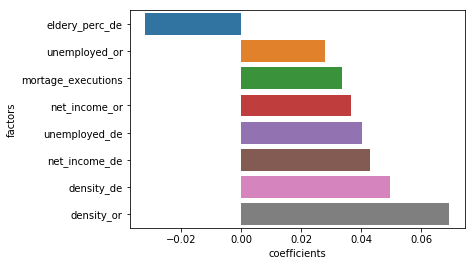

In [32]:
summary_a = summary_a.sort_values(by='coefficients')
sns.barplot(y='factors',x='coefficients', data=summary_a[summary_a['p-values'] < alpha])
significant_factors_a = summary_a[summary_a['p-values'] < alpha]

In [33]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(Y_a, y_pred_a))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(Y_a, y_pred_a)))

The RMSE in the test data set is: 0.22
 The r2 score in the test data set is: 0.12


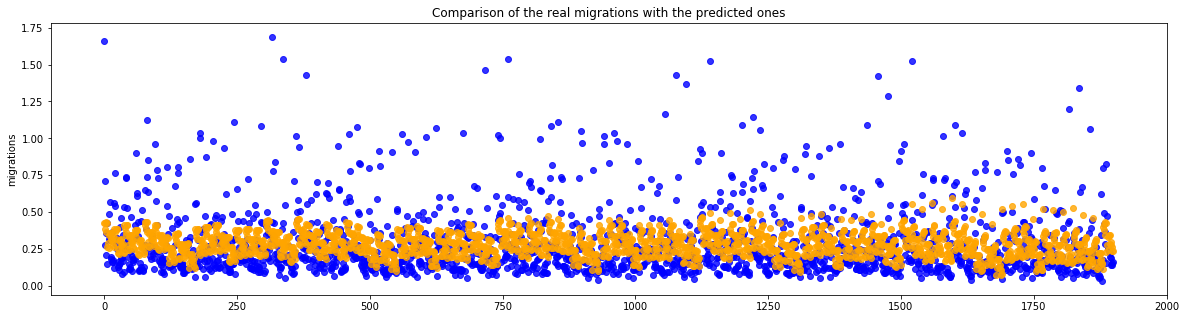

In [34]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(Y_a)), y=Y_a, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_a)), y=y_pred_a, fit_reg=False, color="orange")

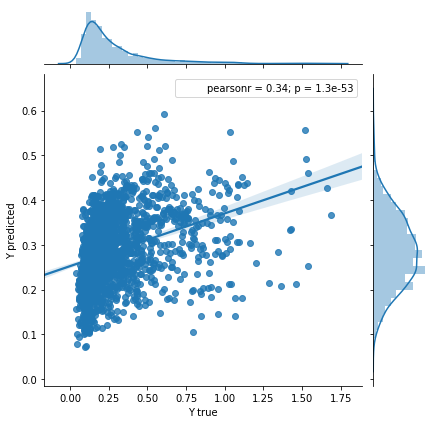

In [35]:
_=sns.jointplot(x=Y_a, y=y_pred_a, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Comparison of factors overall and per period

In [36]:
set(significant_factors.factors.tolist() + significant_factors_a.factors.tolist() + \
              significant_factors_d.factors.tolist() + significant_factors_b.factors.tolist())

{'density_de',
 'density_or',
 'eldery_perc_de',
 'mortage_executions',
 'net_income_de',
 'net_income_or',
 'unemployed_de',
 'unemployed_or',
 'var_n_biz'}

In [37]:
# Define unique existing factors and output structure
factors = set(significant_factors.factors.tolist() + significant_factors_a.factors.tolist() + \
              significant_factors_d.factors.tolist() + significant_factors_b.factors.tolist())

factors_ = ['density_de', 'density_or', 'net_income_or','net_income_de', 'unemployed_de', 'unemployed_or', 
            'rev_1000_inh_or', 'var_review_or', 'n_tran_new_rs_de', 'n_tran_new_rs_or','var_rent_m2_or',
            'var_rent_m2_de', 'var_sale_m2_de', 'var_sale_m2_or', 'euribor','var_n_biz', 'mortage_executions']

# Assign coeficient values to each period
period_names = ['whole period', 'before_crisis', "between_crisis", "after_crisis"]
periods = [significant_factors, significant_factors_b, significant_factors_d, significant_factors_a]
results = []
for period in range(len(periods)):
    df = periods[period].loc[:,('factors','coefficients')]
    df['period'] = period_names[period]
    results.append(df)
significant_facts = pd.concat(results)
significant_facts["factors"] = significant_facts["factors"].astype("category", categories=factors_, ordered=True)
significant_facts = significant_facts.dropna()

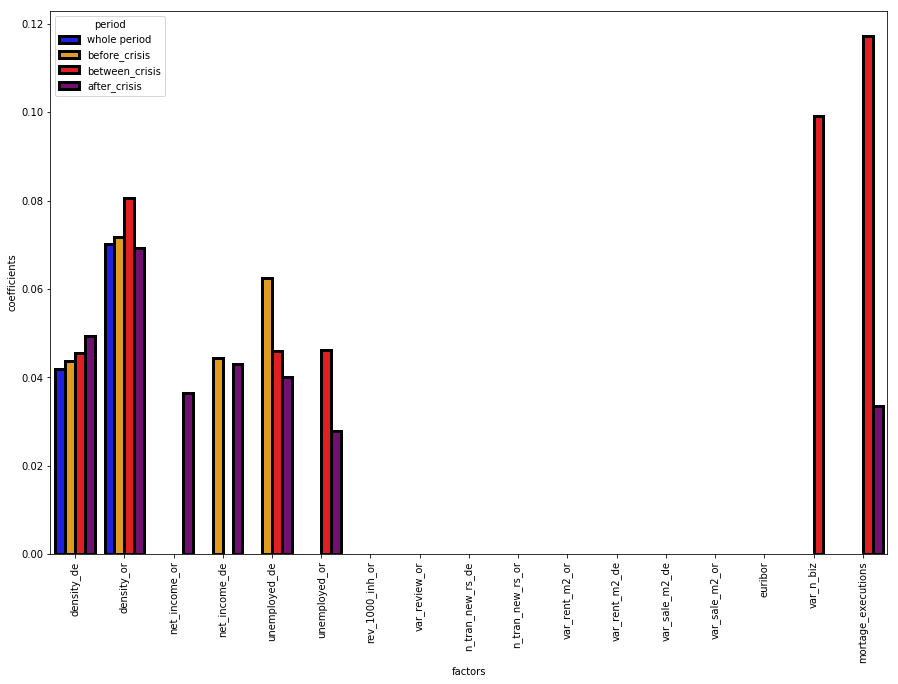

In [38]:
_=plt.figure(figsize=(15, 10))
_=sns.barplot(x='factors',y='coefficients',data=significant_facts, hue='period', palette=['blue','orange','red','purple'],
              linewidth=3, edgecolor='black')
_=plt.xticks(rotation=90)

Text(0.5,1,'2007-2017')

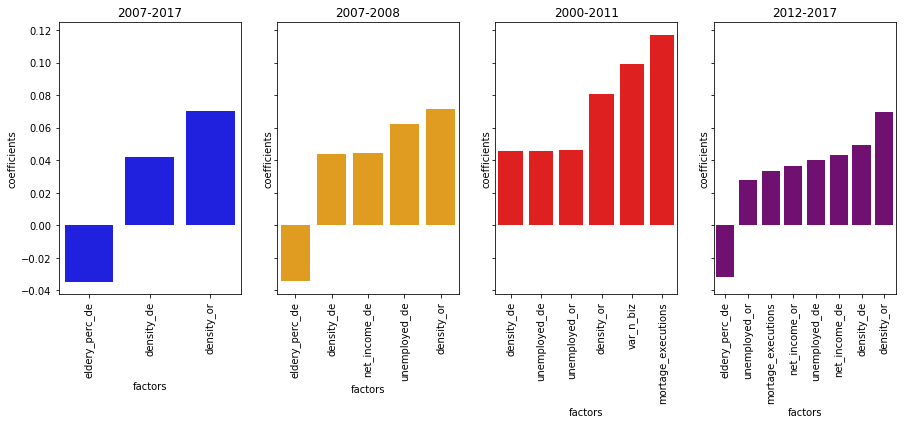

In [39]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15,5))
sns.barplot(x='factors',y='coefficients',data=significant_factors_b,color='orange',label='before crisis', ax=ax2)
sns.barplot(x='factors',y='coefficients',data=significant_factors_d,color='red',label='during crisis', ax=ax3)
sns.barplot(x='factors',y='coefficients',data=significant_factors_a,color='purple',label='after crisis', ax=ax4)
sns.barplot(x='factors',y='coefficients',data=significant_factors,color='blue',label='after crisis', ax=ax1)
for i,ax in enumerate(f.axes):
    plt.sca(ax)
    plt.xticks(rotation=90)
ax2.set_title("2007-2008")
ax3.set_title("2000-2011")
ax4.set_title("2012-2017")
ax1.set_title("2007-2017")